In [2]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

In [3]:
#def reset_esn()の定義
#reset_esn()は一体何に使うのか？

def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [4]:
# 描画用のplot_generationの定義

def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [5]:
nb_generations = 400
seed_timesteps= 100

In [6]:
def multi_generative_model(X, N, iss, lr, ridge, seed, sr, train_len = 2000, forecast=1, seed_timesteps = 100, nb_generations = 400):
    
    n, m = X.shape
    
    from reservoirpy.datasets import to_forecasting

    train_len = train_len

    x, y = to_forecasting(X, forecast=forecast)
    X_train, y_train = x[:train_len], y[:train_len]
    X_test, y_test = x[train_len:], y[train_len:]

    dataset = ((X_train, y_train), (X_test, y_test))
    
    # bestから取得したハイパーパラメータを設定
    N = N
    iss = iss
    lr = lr
    ridge = ridge
    seed = seed
    sr = sr

    # データセットからトレーニングとバリデーションデータを取得
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data

    # モデルの構築
    reservoir = Reservoir(N, 
                        sr=sr, 
                        lr=lr, 
                        input_scaling=iss, 
                        seed=seed)
    readout = Ridge(ridge=ridge)
    model = reservoir >> readout

    # モデルの訓練と予測
    predictions = model.fit(X_train, y_train).run(X_val)
    
    seed_timesteps = seed_timesteps

    warming_inputs = X_test[:seed_timesteps]

    warming_out = model.run(warming_inputs, reset=True)  # warmup
    
    nb_generations = nb_generations

    X_gen = np.zeros((nb_generations, m))
    y = warming_out[-1]
    for t in range(nb_generations):  # generation
        y = model(y)
        X_gen[t, :] = y
        
    X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]
    
    return X_gen, X_t, warming_out, warming_inputs

In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt

def phase_shift(t):
    # 2πは1日に対応します。8時間は(8/24)*2πに対応します。
    shift_value = (8/24)*2*np.pi
    # 4日ごとに位相をシフトします。
    number_of_shifts = int(t / (4*2*np.pi))
    return number_of_shifts * shift_value

def modified_forced_van_der_pol(t, z, mu, A, omega):
    x, y = z  # 値をアンパックします。
    dxdt = y
    # omega*tの項にphase_shiftを追加します。
    dydt = mu * (1 - x**2) * y - x + A * np.sin(omega * t + phase_shift(t))
    return [dxdt, dydt]

mu = 1.0
omega = 1.0
initial_state = [1.0, 0.0]
t_span = (0, 2510)

# グラフの周期的な形状が時折消失するようにAの値を調整します。
A_adjusted = 1.2

# 変更されたVDPモデルでシミュレーションを行います。
sol_modified = solve_ivp(modified_forced_van_der_pol, t_span, initial_state, args=(mu, A_adjusted, omega), dense_output=True, t_eval=np.linspace(t_span[0], t_span[1], 25100), max_step = 0.01)

t_modified = sol_modified.t
x_modified = sol_modified.y[0]
y_modified = sol_modified.y[1]
# sin(omega * t + phase_shift(t)) の計算
s_modified = np.sin(omega * t_modified + np.array([phase_shift(ti) for ti in t_modified]))

data_withouttime = pd.DataFrame({'x': x_modified, 'y': y_modified, 'sin': s_modified})

# CSVファイルを読み込む
data_loaded = pd.read_csv('modified_forced_vanderpol_dataset.csv')

X = data_withouttime.values

In [12]:
X_gen, X_t, warming_out, warming_inputs = multi_generative_model(X, 500, 0.6062643158179813, 0.48657161636196294, 0.00019371347794085468, 1234, 1.3671630828846324)

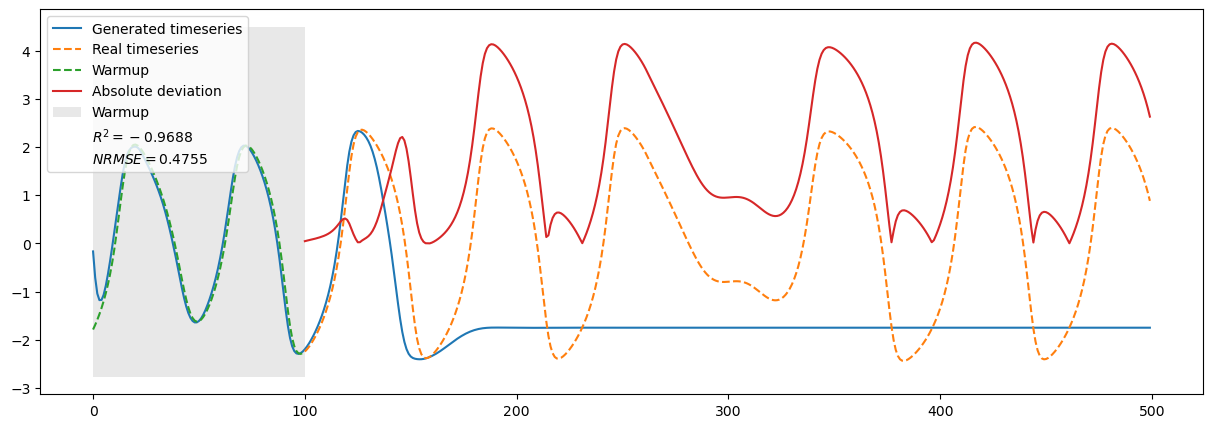

In [13]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

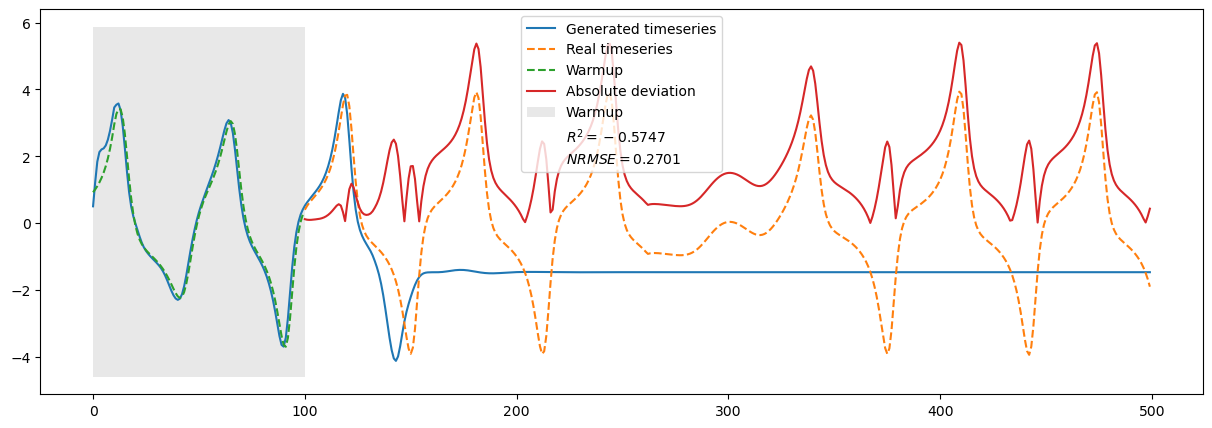

In [14]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)


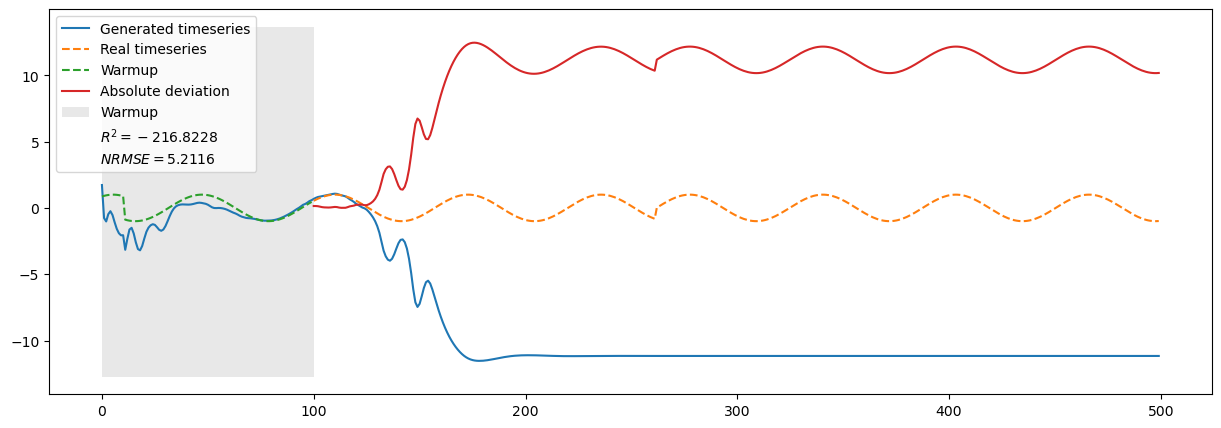

In [15]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)
